In [111]:
from skimage import io, measure, filters, draw
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import pandas as pd

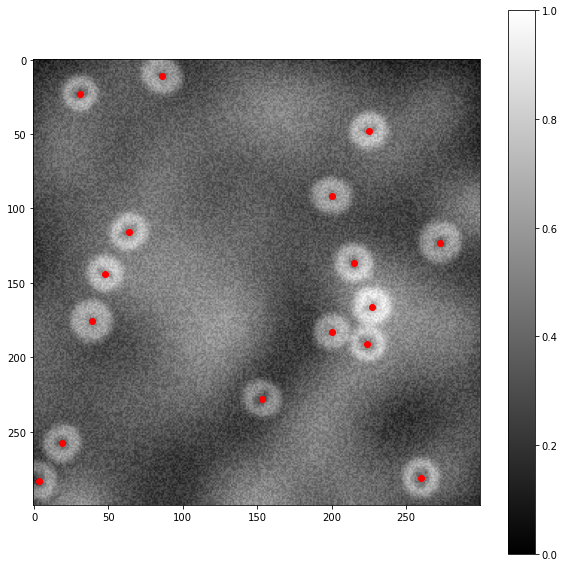

In [113]:
class Simulator:    

    def __init__(self, canvas=(300,300)):
        self.height, self.width = canvas
        self.canvas = np.zeros((self.height, self.width))
        self.mask = np.zeros_like(self.canvas)
        self.ellipse_coordinates = []
        self.layers = []

    def apply_filter(self, filter, args):
        self.canvas = filter(self.canvas, *args)

    def add_noise(self, noise_level):
        self.canvas += np.random.rand(self.height, self.width) * noise_level
    
    def normalize(self):
        self.canvas = self.canvas - self.canvas.min()
        self.canvas = self.canvas / self.canvas.max()

    def add_cells(self, cell_class, n_cells):
        layer = np.zeros_like(self.canvas).astype(bool)
        self.layers.append(layer)
        self.X, self.Y = [], []
        for _ in range(n_cells):
            pos_found = False
            while not pos_found:
                posy = np.random.randint(0, self.height)
                posx = np.random.randint(0, self.width)
                cell = cell_class(self, (posy, posx))
                if not np.any(layer[cell.cytoplasm_i] == 1):
                    pos_found = True
                    layer[cell.cytoplasm_i] = 1
            self.X.append(posx); self.Y.append(posy)
            cell.draw()
        df = pd.DataFrame({"x": self.X, "y": self.Y})
        df.sort_values(by=['x'], inplace=True)
        self.X = df['x'].values; self.Y = df['y'].values
        
class Cell:
    def __init__(self, sim:Simulator, pos:tuple):
        self.sim = sim
        self.y, self.x = pos

    def generate_shape(self, borders, shape='ellipse'):
        rmin, rmax = borders
        rx = np.random.randint(rmin, rmax)
        ry = np.random.randint(rmin, rmax)
        rot = np.deg2rad(np.random.randint(0, 360))
        if shape == 'ellipse':
            rr, cc = draw.ellipse(self.y, self.x, ry, rx, rotation = rot, shape=self.sim.canvas.shape)

        return rr, cc

class Ellipse_cell(Cell):
    cytoplasm_r = (5, 20)
    nucleus_r = (2,8)

    def __init__(self, sim:Simulator, pos:tuple):
        super().__init__(sim, pos)
        self.add_cytoplasm()
        self.add_nucleus()
        self.channels = [
            (self.cytoplasm_i, 1.0),
            (self.nucleus_i, 0.0)
        ]

    def draw(self):
        for (channel, value) in self.channels:
            self.sim.canvas[channel] = value

    def add_cytoplasm(self):
        self.cytoplasm_i = self.generate_shape(self.cytoplasm_r)

    def add_nucleus(self):
        self.nucleus_i = self.generate_shape(self.nucleus_r)

BG = Simulator()
BG.add_cells(Ellipse_cell, 100)
BG.apply_filter(filters.gaussian, args=(20,))
BG.normalize()


sim = Simulator()
Ellipse_cell.cytoplasm_r = (12,15)
Ellipse_cell.nucleus_r = (2,8)
sim.add_cells(Ellipse_cell, 16)
sim.apply_filter(filters.gaussian, args=(2,))
sim.add_noise(.6)
sim.normalize()

sim.canvas = sim.canvas + BG.canvas
sim.normalize()

plt.figure(figsize=(10,10))
plt.imshow(sim.canvas, cmap='gray')
plt.colorbar()

plt.scatter(sim.X, sim.Y, color='red')
plt.show()
    

In [ ]:
class DataGenerator:

    def __init__(self):
        pass

    def generate(self):
        BG = Simulator()
        BG.add_cells(Ellipse_cell, 100)
        BG.apply_filter(filters.gaussian, args=(20,))
        BG.normalize()

        sim = Simulator()
        Ellipse_cell.cytoplasm_r = (12,15)
        Ellipse_cell.nucleus_r = (2,8)
        sim.add_cells(Ellipse_cell, 15)
        sim.apply_filter(filters.gaussian, args=(2,))
        sim.add_noise(.6)
        sim.normalize()

        sim.canvas = sim.canvas + BG.canvas
        sim.normalize()

        return sim.canvas, (sim.X, sim.Y)


